In [191]:
# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize,medial_axis,thin,rectangle
from skimage import img_as_bool, io, color, data, util
from skimage.transform import resize
import networkx as nx
import sknw
import hdbscan
from sklearn.cluster import AgglomerativeClustering
from tensorflow.keras.utils import load_img 
from tqdm import tqdm
import gmatch4py as gm
import cv2
import node2vec

# Calcul de similitude par graph edit distance

In [429]:
path = 'C:/Users/utilisateur/Desktop/Projet de recherche/SIG/Parcelles_Vasserot/Parcelles_Vasserot_Carre_Aligne_Rue'
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filenames
parcelles = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.jpg'):
          # adds only the image files to the list
            parcelles.append(file.name)

In [430]:
def extract_complex_skeleton(parcelle):
    image = ~img_as_bool(color.rgb2gray(io.imread(parcelle)))
    ax = medial_axis(image).astype(np.uint16)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    dilation = cv2.dilate(ax,kernel,iterations = 10)
    ske = skeletonize(image).astype(np.uint16)
    graph = sknw.build_sknw(ske)
    return(graph)

def extract_axis_normal(parcelle):
    image = ~img_as_bool(color.rgb2gray(io.imread(parcelle)))
    ax = medial_axis(image).astype(np.uint16)
    graph = sknw.build_sknw(ax)
    return(graph)

def extract_skeleton(parcelle):
    image = ~img_as_bool(color.rgb2gray(io.imread(parcelle)))
    ske = skeletonize(image).astype(np.uint16)
    graph = sknw.build_sknw(ske)
    return(graph)

#lent!
def extract_thin(parcelle):
    image = ~img_as_bool(color.rgb2gray(io.imread(parcelle)))
    th = mahotas.thin(image).astype(np.uint16)
    graph = sknw.build_sknw(th)
    return(graph)

In [431]:
graphs = {}
p = 'C:/Users/utilisateur/Desktop/Projet de recherche/SIG/Parcelles_Vasserot/Parcelles_Vasserot_Graphes'

# lop through each image in the dataset
for parcelle in tqdm(parcelles):
    # try to extract the features and update the dictionary
    try:
        feat = extract_complex_skeleton(parcelle)
        graphs[parcelle] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(graphs,file)

100%|████████████████████████████████████████████████████████████████████████████████| 361/361 [05:34<00:00,  1.08it/s]


In [432]:
ged = gm.GraphEditDistance(1,1,1,0) # all edit costs are equal to 1
dist_mat = ged.compare(list(graphs.values()),None)

In [385]:
#Calcul lent avec NetworkX

dim = 30

dist_mat = np.zeros((dim,dim))

for i in range(dim):
    for j in tqdm(range(i,dim)):
        for v in nx.optimize_edit_paths(data[i],data[j]):
            dist = v[-1]
        dist_mat[i][j] = dist
        dist_mat[j][i] = dist

In [433]:
dist_mat

array([[0.00000000e+00, 3.98617886e+02, 9.82950548e+02, ...,
        2.75293501e+03, 9.81950548e+02, 2.75293501e+03],
       [8.00000000e+00, 0.00000000e+00, 2.12882821e+02, ...,
        5.26848903e+02, 2.15882821e+02, 5.25848903e+02],
       [1.20000000e+01, 3.00000000e+00, 0.00000000e+00, ...,
        6.77538239e+02, 3.00000000e+00, 6.77538239e+02],
       ...,
       [8.00000000e+00, 8.00000000e+00, 4.00000000e+00, ...,
        0.00000000e+00, 2.00000000e+00, 2.00000000e+00],
       [8.00000000e+00, 6.00000000e+00, 3.00000000e+00, ...,
        8.34781449e+02, 0.00000000e+00, 8.37781449e+02],
       [1.00000000e+01, 6.00000000e+00, 4.00000000e+00, ...,
        2.00000000e+00, 5.00000000e+00, 0.00000000e+00]])

In [437]:
#clustering = hdbscan.HDBSCAN(metric='precomputed')
clustering = AgglomerativeClustering(n_clusters=100, metric='precomputed', linkage='complete')
clustering.fit(dist_mat)
print(clustering.labels_)

[67 14 11  8  4  4  4 18  0  8  5 38  8  3  0 18  4  4  0  4 23  0  4  0
  8  4  5 65  8  4  8  0  4  4  4  3  8  8  8 18  4  0  0  4 18  0  0  4
  8 18 38 85 22 21  5  0  0  0  8  1  8  8 18  4  0  0  0  8 18  0  2 55
 14  8  0 11 18  0  1  8 11  0  4  4 18  4  4 11  4  0  4  4 18  4  0  7
  8  4  8 18  8  4 18 10  4  0  4  4 12 18 83  8  4  4  8 18  0 18 18 18
 18  0 18  4  8 18  8  4  7 18 37  8 11  8  0  0  4  4  0  4  4  8  4  4
  8  0  0 38  8  0 79  0  0 12 18  0  0  4  8  4  0 18  4  8  4 18  6  4
  0  3  4  1  0  8  8  0 23 24  0 69  4 18  0 18  1  8  0  8  0  8 23  0
 59 18  8  4  0 18  8 18  4  9  8 87 81 57 51  7  0  4 13  9  0 11  6  4
  4  4  8  4  9  5  8 18 63 18 73  8  4 12 18 18 64 18 90  8 22 61  8 18
 18  6 13  8  8 53 18 18 89  8  8  8  8 88  5 18 37 68  9  0  8  8 18 92
  8  2  8 84 18  8 23  0  0 18  0 71  0 18 21 18  8  3  7 43  2  8 60 86
  1  0  1  0 12 29 58  3  0 18 42 41 20  9 28 82 80  0  0  6  1 56 27  0
 40 54 39 26  1 52 77 76 75 25 78 50 74 36 99 97 72

In [438]:
# holds the cluster id and the images { id: [images] }
filenames = np.array(list(graphs.keys()))
graphs_v = np.array(list(graphs.values()))

groups = {}
data_clustered = {}

for file, graph, cluster in zip(filenames,graphs_v,clustering.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        data_clustered[cluster] = []
        groups[cluster].append(file)
        data_clustered[cluster].append(graph)
    else:
        groups[cluster].append(file)
        data_clustered[cluster].append(graph)
        
path = 'C:/Users/utilisateur/Desktop/Projet de recherche/SIG/Parcelles_Vasserot/Parcelles_Vasserot_Carre_Aligne_Rue'
# change the working directory to the path where the images are located
os.chdir(path)

C:\Users\utilisateur\AppData\Local\Temp\ipykernel_45868\2631362469.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  graphs_v = np.array(list(graphs.values()))


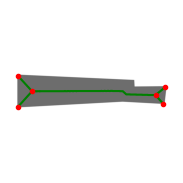

In [442]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    graphs = data_clustered[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 99:
        print(f"Clipping cluster size from {len(files)} to 99")
        files = files[:98]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        # draw edges by pts
        graph = graphs[index]
        for (s,e) in graph.edges():
            ps = graph[s][e]['pts']
            plt.plot(ps[:,1], ps[:,0], 'green')
    
        # draw node by o
        nodes = graph.nodes()
        ps = np.array([nodes[i]['o'] for i in nodes])
        plt.plot(ps[:,1], ps[:,0], 'r.')
        plt.axis('off')

view_cluster(9)

# Exemple d'extraction du graphe de la géométrie

In [194]:
graph = graphs[332]
img = ~img_as_bool(color.rgb2gray(io.imread(parcelles[332])))

# draw image
plt.imshow(img, cmap='gray')

# draw edges by pts
for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    plt.plot(ps[:,1], ps[:,0], 'green')
    
# draw node by o
nodes = graph.nodes()
ps = np.array([nodes[i]['o'] for i in nodes])
plt.plot(ps[:,1], ps[:,0], 'r.')

# title and show
plt.title('Build Graph')
plt.show()

TypeError: 'module' object is not subscriptable

In [ ]:
image = cv2.cvtColor(io.imread(parcelles[0]), cv2.COLOR_RGB2GRAY)
image = ~image
img1 = image.copy()

# Structuring Element
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
# Create an empty output image to hold values
thin = np.zeros(image.shape,dtype='uint8')
 
# Loop until erosion leads to an empty set
while (cv2.countNonZero(img1)!=0):
    # Erosion
    erode = cv2.erode(img1,kernel)
    # Opening on eroded image
    opening = cv2.morphologyEx(erode,cv2.MORPH_OPEN,kernel)
    # Subtract these two
    subset = erode - opening
    # Union of all previous sets
    thin = cv2.bitwise_or(subset,thin)
    # Set the eroded image for next iteration
    img1 = erode.copy()

#ax = cv2.ximgproc.thinning(thin,thinningType=cv2.ximgproc.THINNING_GUOHALL)
graph = sknw.build_sknw(thin)

In [409]:
image = ~img_as_bool(color.rgb2gray(io.imread(parcelles[2])))
ax = thin(image).astype(np.uint16)
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
#closing = cv2.morphologyEx(ax, cv2.MORPH_CLOSE, kernel)
#opening = cv2.morphologyEx(ax, cv2.MORPH_OPEN, kernel)
dilation = cv2.dilate(ax,kernel,iterations = 10)
ske = skeletonize(dilation).astype(np.uint16)
graph = sknw.build_sknw(ske)

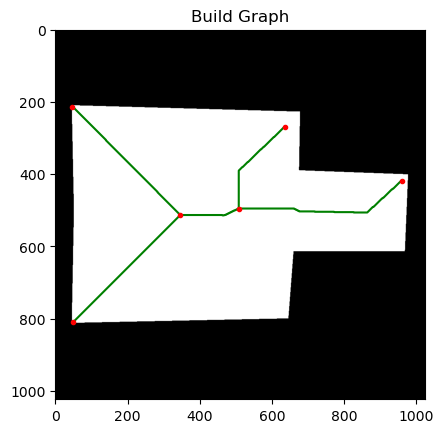

In [410]:
# draw image>

plt.imshow(image, cmap='gray')

# draw edges by pts
for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    plt.plot(ps[:,1], ps[:,0], 'green')
    
# draw node by o
nodes = graph.nodes()
ps = np.array([nodes[i]['o'] for i in nodes])
plt.plot(ps[:,1], ps[:,0], 'r.')

# title and show
plt.title('Build Graph')
plt.show()